In [1]:
import os
import numpy as np
import zarr
from PIL import Image
from IPython.display import display
from tqdm.notebook import tqdm, trange

In [2]:
scene = 'sponza'

In [3]:
# Field of view
fov_factor = 2.0
fov = 2 * np.arctan(fov_factor / 2) * 180/np.pi

In [4]:
# Plane U
z_u = 0.0
n_u = 20
size_u = 10.0
pitch_u = size_u / n_u

# Plane V
z_v = 265.0
n_v = 1080
size_v = 540.0
pitch_v = size_v / n_v

# View chunks.
chunk_v = 40
n_chunk = n_v//chunk_v

print('[Sampled Light Field]')
print('Plane U:    {:4} × {:4.2f} mm = {:5} mm    z_u = {:5} mm'.format(n_u, pitch_u, size_u, z_u))
print('Plane V:    {:4} × {:4.2f} mm = {:5} mm    z_v = {:5} mm'.format(n_v, pitch_v, size_v, z_v))
print('          ({:2}×{:2})'.format(n_chunk, chunk_v))

print('\n[Retina Estimate with FoV = {:4.1f}°]'.format(fov))
print('Focus at U: {:7.2f}'.format(fov_factor * z_u / pitch_u))
print('Focus at V: {:7.2f}'.format(fov_factor * z_v / pitch_v))
print('Focus at ∞: {:7.2f}'.format(fov_factor * abs(z_u - z_v) / max(pitch_u, pitch_v)))

print('\nNumber of rays: {:,}'.format((n_u * n_v)**2))

[Sampled Light Field]
Plane U:      20 × 0.50 mm =  10.0 mm    z_u =   0.0 mm
Plane V:    1080 × 0.50 mm = 540.0 mm    z_v = 265.0 mm
          (27×40)

[Retina Estimate with FoV = 90.0°]
Focus at U:    0.00
Focus at V: 1060.00
Focus at ∞: 1060.00

Number of rays: 466,560,000


In [5]:
def bytesize_string(nbytes):
    unit =          ['B',  'KiB' ,  'MiB' ,  'GiB' ,  'TiB' ,  'PiB' ,  'EiB' ,  'ZiB' ,  'YiB' ]
    size = np.array([ 1 , 1/2**10, 1/2**20, 1/2**30, 1/2**40, 1/2**50, 1/2**60, 1/2**70, 1/2**80]) * nbytes
    order_of_magnitude = np.argmax(size < 1.0) - 1
    return '{} {}'.format(size[order_of_magnitude], unit[order_of_magnitude])

def array_stats(a):
    print('{} × {} = {} | min: {}, max: {}, avg: {}'.format(a.shape, a.dtype, bytesize_string(a.nbytes), np.amin(a), np.amax(a), np.average(a)))
    
def display_image(values):
    display(Image.fromarray((np.flip(np.swapaxes(values, 0, 1), axis=0) * 255.0).astype(np.uint8)))

def sampling_lattice(n, pitch=1.0):
    return (np.arange(n, dtype=np.float32) - (n - 1)/2) * pitch

def dot(a, b):
    return np.einsum('...i,...i', a, b)

In [6]:
%%time

data = np.empty((n_u, n_chunk, chunk_v, n_u, n_chunk, chunk_v, 3), dtype=np.float32)

print('Reading view images...')
for idx_view, idy_view in tqdm(np.ndindex(n_u, n_u), total=n_u*n_u):
    with Image.open('data/exported_views/view-{}-{}.png'.format(idx_view+1, idy_view+1)) as img:
        view = np.swapaxes(np.flip(np.array(img.convert('RGB')), axis=0), 0, 1) / 255.0
        data[idx_view, :, :, idy_view, :, :, :] = view.reshape(n_chunk, chunk_v, n_chunk, chunk_v, 3)

array_stats(data)

Reading view images...


  0%|          | 0/400 [00:00<?, ?it/s]

(20, 27, 40, 20, 27, 40, 3) × float32 = 5.214214324951172 GiB | min: 0.0, max: 1.0, avg: 0.27192768454551697
Wall time: 26.5 s


In [7]:
%%time

print('Creating the light field array...')
light_field = zarr.open('data/' + scene + '_sampled.zarr', mode='w', shape=(n_u, n_chunk, chunk_v, n_u, n_chunk, chunk_v, 3), chunks=(n_u, 1, chunk_v, n_u, 1, chunk_v, 3), dtype=np.float32)

for idx_chunk, idy_chunk in tqdm(np.ndindex(n_chunk, n_chunk), total=n_chunk*n_chunk):
    light_field[:, idx_chunk, :, :, idy_chunk, :, :] = data[:, idx_chunk, :, :, idy_chunk, :, :]

display(light_field.info)

Creating the light field array...


  0%|          | 0/729 [00:00<?, ?it/s]

Type               : zarr.core.Array
Data type          : float32
Shape              : (20, 27, 40, 20, 27, 40, 3)
Chunk shape        : (20, 1, 40, 20, 1, 40, 3)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 5598720000 (5.2G)
No. bytes stored   : 3225263092 (3.0G)
Storage ratio      : 1.7
Chunks initialized : 729/729

Wall time: 9.04 s


  0%|          | 0/729 [00:00<?, ?it/s]

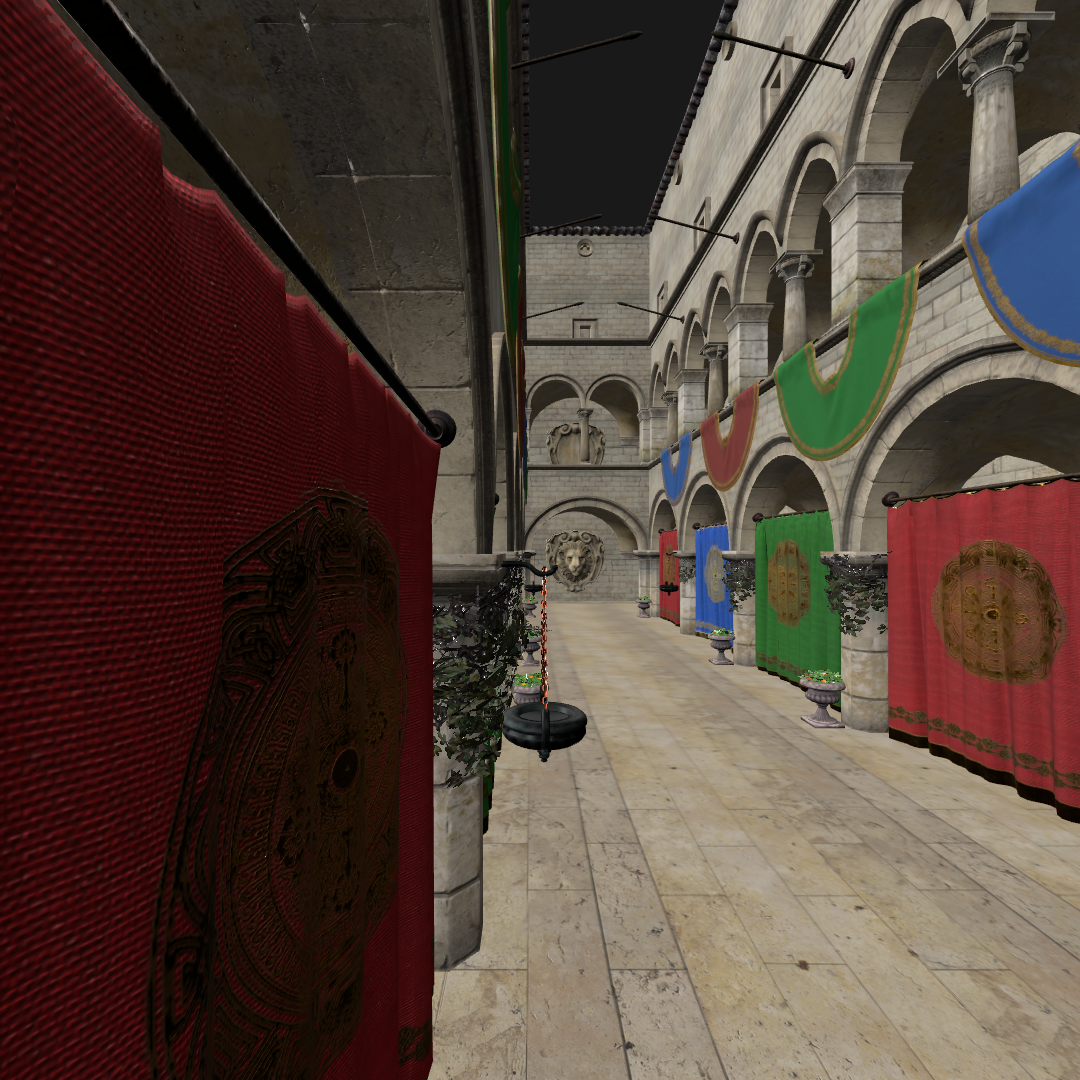

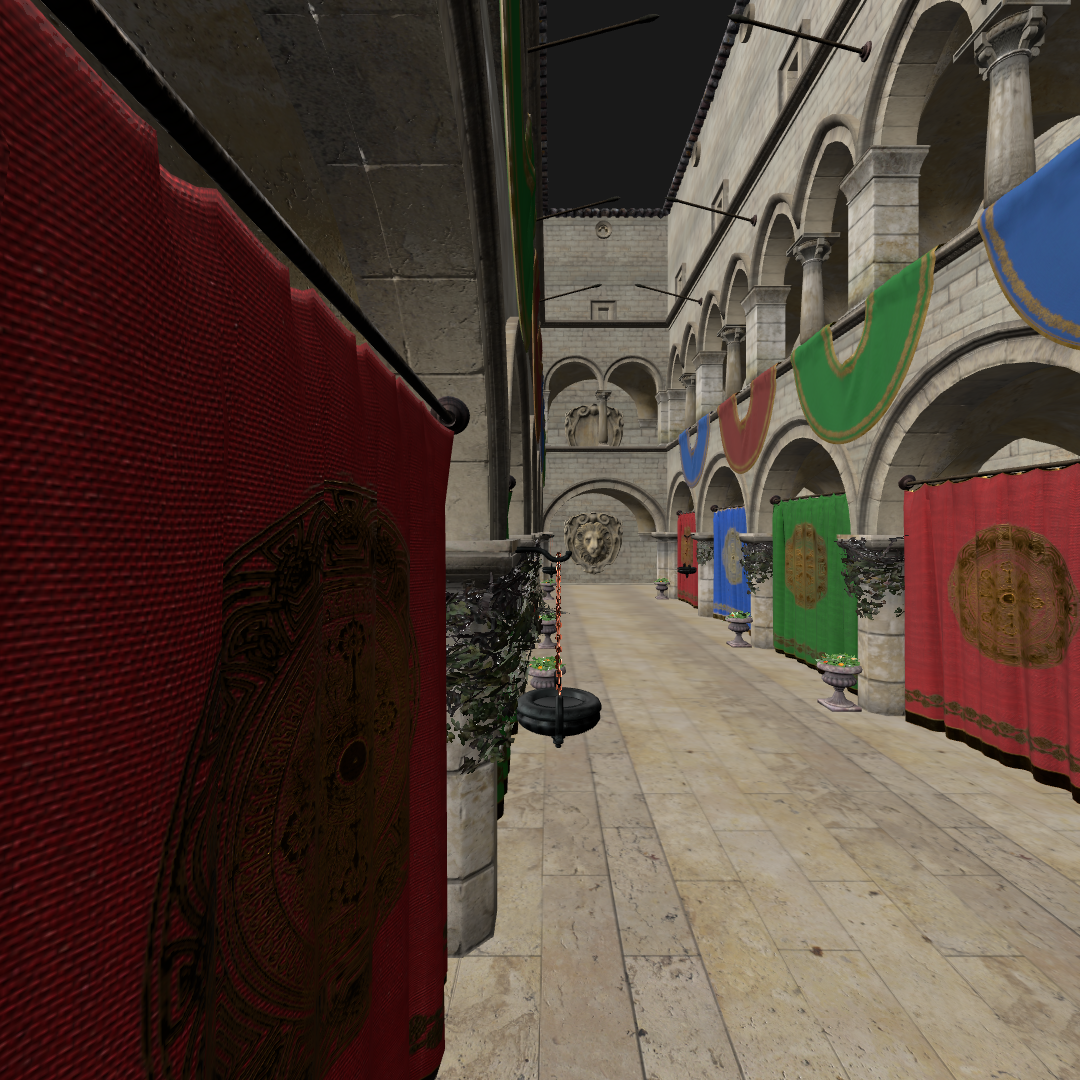

Wall time: 10.8 s


In [8]:
%%time

light_field = zarr.open('data/' + scene + '_sampled.zarr', mode='r')

first_view = np.zeros((n_chunk, chunk_v, n_chunk, chunk_v, 3), dtype=np.float32)
last_view  = np.zeros((n_chunk, chunk_v, n_chunk, chunk_v, 3), dtype=np.float32)

for idx_chunk, idy_chunk in tqdm(np.ndindex(n_chunk, n_chunk), total=light_field.nchunks):
    sample_values = light_field[:, idx_chunk, :, :, idy_chunk, :, :]

    first_view[idx_chunk, :, idy_chunk, :, :] = sample_values[ 0, :,  0, :, :]
    last_view[ idx_chunk, :, idy_chunk, :, :] = sample_values[-1, :, -1, :, :]

display_image(first_view.reshape(n_v, n_v, 3))
display_image( last_view.reshape(n_v, n_v, 3))